# Policy Gradient

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import random
import os
import functools
import time
import gin
import PIL
import imageio

from absl import app
from absl import flags
from absl import logging

import gym
from gym.envs.registration import register
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from IPython import display

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

1 Physical GPUs, 1 Logical GPUs


## Environment Setup

In [2]:
env_name = 'LunarLander-v2'
random_seed = 42

ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Params for train
num_iterations = 200
max_episodes = 16
gamma = 0.99
learning_rate = 0.005
loss_fn = keras.losses.sparse_categorical_crossentropy
activation_fn = "softmax"

keras.backend.clear_session()
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

## Policy Gradient

In [3]:
class PGN:
    def __init__(self, state_dim, action_dim, activation_fn="softmax", loss_fn=keras.losses.sparse_categorical_crossentropy, gamma=0.99, learning_rate=0.005):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lr = learning_rate
        self.loss_fn = loss_fn
        self.optimizer = Adam(lr=self.lr)
        
        self.checkpoint_folder = os.path.join(ROOT_DIR, "training/PGN")
        os.makedirs(self.checkpoint_folder, exist_ok=True)
        self.checkpoint_path = os.path.join(self.checkpoint_folder, 'cp-{epoch:04d}.ckpt')
        self.checkpoint_dir = os.path.dirname(self.checkpoint_path)

        self.model = self.create_model()

    def create_model(self):
        model = tf.keras.Sequential([
            Input((self.state_dim)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_dim, activation=activation_fn)
        ])
        return model
    
    def get_action(self, obs):
        probas = self.model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        return action, probas
    
    def grads(self, obs):
        with tf.GradientTape() as tape:
            action, probas = self.get_action(obs)
            loss = tf.reduce_mean(self.loss_fn(action, probas))
        grads = tape.gradient(loss, self.model.trainable_variables)
        return action, grads
    
    def discount_rewards(self, rewards):
        discounted = np.array(rewards)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += discounted[step + 1] * self.gamma
        return discounted

    def discount_and_normalize_rewards(self, all_rewards):
        all_discounted_rewards = [self.discount_rewards(rewards) for rewards in all_rewards]
        flat_rewards = np.concatenate(all_discounted_rewards)
        reward_mean = flat_rewards.mean()
        reward_std = flat_rewards.std()
        return [((discounted_rewards - reward_mean) / reward_std) for discounted_rewards in all_discounted_rewards]

    def train(self, all_rewards, all_grads):
        all_mean_grads = []
        all_final_rewards = self.discount_and_normalize_rewards(all_rewards)
        for var_index in range(len(self.model.trainable_variables)):
            mean_grads = tf.reduce_mean(
                [final_reward * all_grads[episode_index][step][var_index]
                 for episode_index, final_rewards in enumerate(all_final_rewards)
                     for step, final_reward in enumerate(final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        self.optimizer.apply_gradients(zip(all_mean_grads, self.model.trainable_variables))
    
    def load(self, weights=''):
        if weights:
             self.model.load_weights(weights)
        else:
            latest = tf.train.latest_checkpoint(self.checkpoint_dir)
            if latest is not None:
                self.model.load_weights(latest)

    def save(self, e):
        self.model.save_weights(self.checkpoint_path.format(epoch=e))
    
    def clean(self):
        for f in os.listdir(self.checkpoint_folder):
            os.remove(os.path.join(self.checkpoint_folder, f))

## Agent Class

In [4]:
class Agent:
    def __init__(self, env_name, random_seed=42, activation_fn="softmax", loss_fn=keras.losses.MeanSquaredError(), gamma=0.95, learning_rate=0.005):
        self.env = gym.make(env_name)
        self.env.seed(random_seed)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = gamma
        
        self.frames = []
        self.rewards = []
        
        self.image_name = env_name + ".gif"
        self.image_path = os.path.join(IMAGES_PATH, self.image_name)
        
        self.main_model = PGN(self.state_dim, self.action_dim, activation_fn, loss_fn, self.gamma, learning_rate)
        
    def cp_init(self):
        self.main_model.clean()
        
    def convert_time(self, t):
        hours, rem = divmod(t, 3600)
        minutes, seconds = divmod(rem, 60)
        return hours, minutes, seconds
    
    def make_gif(self):
        frame_images = [PIL.Image.fromarray(frame) for frame in self.frames]
        frame_images[0].save(self.image_path, format='GIF', append_images=frame_images[1:], save_all=True, duration=120, loop=0)
    
    def get_gif(self):
        html_img = '<img src=' + self.image_path + ' />'
        return html_img
    
    def show_gif(self):
        display.HTML(self.get_gif())

    def plot_rewards(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.rewards)
        plt.xlabel("Episode", fontsize=14)
        plt.ylabel("Reward", fontsize=14)
        plt.grid()
        plt.show()
    
    def train(self, num_iterations=200, max_episodes=16):
        train_time = 0
        mean_rewards = []
        self.main_model.load()
        self.main_model.clean()
        for iteration in range(num_iterations):
            all_rewards = []
            all_grads = []
            start_time = time.time()
            for ep in range(max_episodes):
                done = False
                current_rewards = []
                current_grads = []
                obs = self.env.reset()
                while not done:
                    action, grads = self.main_model.grads(obs)
                    obs, reward, done, _ = self.env.step(action[0, 0].numpy())
                    current_rewards.append(reward)
                    current_grads.append(grads)
                all_rewards.append(current_rewards)
                all_grads.append(current_grads)
            mean_reward = sum(map(sum, all_rewards)) / max_episodes
            mean_rewards.append(mean_reward)
            self.main_model.train(all_rewards, all_grads)
            train_time += time.time() - start_time
            hours, minutes, seconds = self.convert_time(train_time)
            print("\rIteration: {} / {}, Mean Reward: {:.1f}, Train Time: {:0>2}:{:0>2}:{:05.2f}".format(iteration, num_iterations, mean_reward, int(hours), int(minutes), seconds), end="")
            self.main_model.save(ep)
        self.rewards = mean_rewards

    def play(self):
        self.frames = []
        total_reward, step_indx = 0, 0
        obs = self.env.reset()
        while True:
            self.frames.append(self.env.render(mode="rgb_array"))
            action, _ = self.main_model.get_action(obs)
            obs, reward, done, info = self.env.step(action[0, 0].numpy())
            total_reward += reward
            step_indx += 1
            print("\rTimestep: {}, Reward: {:.5f}".format(step_indx, total_reward), end="")
            if done:
                break
        self.env.close()

## Train

In [5]:
agent = Agent(env_name, random_seed, activation_fn, loss_fn, gamma, learning_rate)

In [6]:
agent.cp_init()

In [7]:
agent.train(num_iterations, max_episodes)

Iteration: 199 / 200, Mean Reward: 136.5, Train Time: 00:08:31.23

## Display Results

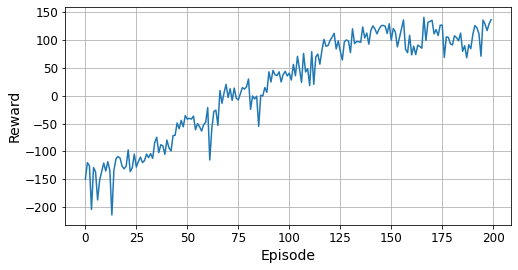

In [8]:
agent.plot_rewards()

## Play

In [9]:
agent.play()

Timestep: 1000, Reward: 137.23284

In [10]:
agent.make_gif()

In [11]:
display.HTML(agent.get_gif())